In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.amp import GradScaler, autocast
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

device = torch.device('cuda')
print('device:', device)
print('gpu:', torch.cuda.get_device_name(0))

device: cuda
gpu: NVIDIA GeForce RTX 5070


In [5]:
voc_root = './'
simclr_path = 'simclr_resnet50.torch'

SEG_BATCH_SIZE = 8
DET_BATCH_SIZE = 4
SEG_EPOCHS = 50
DET_EPOCHS = 25
SEG_LR = 1e-3
DET_LR = 1e-3
IMG_SIZE = 512
NUM_CLASSES_SEG = 21
NUM_CLASSES_DET = 21

In [6]:
def load_simclr_to_resnet_dict(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    trunk = ckpt['classy_state_dict']['base_model']['model']['trunk']
    
    new_dict = {}
    for k, v in trunk.items():
        new_key = k.replace('_feature_blocks.', '')
        new_dict[new_key] = v
    
    return new_dict

simclr_dict = load_simclr_to_resnet_dict(simclr_path)
print('loaded simclr weights:', len(simclr_dict), 'keys')
print('sample keys:', list(simclr_dict.keys())[:5])

loaded simclr weights: 318 keys
sample keys: ['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var']


In [7]:
class VOCSegDataset(Dataset):
    def __init__(self, root, year, image_set, img_size):
        self.img_size = img_size
        voc_path = os.path.join(root, f'VOCdevkit/VOC{year}')
        
        split_file = os.path.join(voc_path, f'ImageSets/Segmentation/{image_set}.txt')
        with open(split_file) as f:
            self.ids = [x.strip() for x in f.readlines()]
        
        self.img_dir = os.path.join(voc_path, 'JPEGImages')
        self.mask_dir = os.path.join(voc_path, 'SegmentationClass')
        
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        
        img = Image.open(os.path.join(self.img_dir, img_id + '.jpg')).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, img_id + '.png'))
        
        img = img.resize((self.img_size, self.img_size), Image.BILINEAR)
        mask = mask.resize((self.img_size, self.img_size), Image.NEAREST)
        
        img = transforms.ToTensor()(img)
        img = self.normalize(img)
        
        mask = torch.from_numpy(np.array(mask)).long()
        mask[mask == 255] = 21
        
        return img, mask

In [8]:
class VOCDetDataset(Dataset):
    def __init__(self, root, year, image_set):
        voc_path = os.path.join(root, f'VOCdevkit/VOC{year}')
        
        split_file = os.path.join(voc_path, f'ImageSets/Main/{image_set}.txt')
        with open(split_file) as f:
            self.ids = [x.strip() for x in f.readlines()]
        
        self.img_dir = os.path.join(voc_path, 'JPEGImages')
        self.annot_dir = os.path.join(voc_path, 'Annotations')
        
        self.classes = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat',
                        'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                        'diningtable', 'dog', 'horse', 'motorbike', 'person',
                        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        
        print(f'Caching annotations for {image_set}...')
        self.cached_targets = []
        for img_id in tqdm(self.ids):
            self.cached_targets.append(self._parse_xml(img_id))
            
    def _parse_xml(self, img_id):
        annot_path = os.path.join(self.annot_dir, img_id + '.xml')
        try:
            tree = ET.parse(annot_path)
            root = tree.getroot()
            
            boxes = []
            labels = []
            
            for obj in root.findall('object'):
                name = obj.find('name').text
                if name not in self.class_to_idx:
                    continue
                
                diff = obj.find('difficult')
                if diff is not None and int(diff.text) == 1:
                    continue
                
                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)
                
                if xmax > xmin and ymax > ymin:
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(self.class_to_idx[name])
            
            if len(boxes) == 0:
                boxes = [[0.0, 0.0, 1.0, 1.0]]
                labels = [0]
                
            return {
                'boxes': torch.tensor(boxes, dtype=torch.float32),
                'labels': torch.tensor(labels, dtype=torch.int64)
            }
        except Exception as e:
            print(f"Error parsing {img_id}: {e}")
            return {
                'boxes': torch.tensor([[0.0, 0.0, 1.0, 1.0]], dtype=torch.float32),
                'labels': torch.tensor([0], dtype=torch.int64)
            }
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        
        img = Image.open(os.path.join(self.img_dir, img_id + '.jpg')).convert('RGB')
        img = transforms.ToTensor()(img)
        img = self.normalize(img)
        
        target = self.cached_targets[idx].copy()
        target['image_id'] = torch.tensor([idx])
        
        return img, target

def det_collate_fn(batch):
    return tuple(zip(*batch))


In [9]:
train_seg = VOCSegDataset(voc_root, '2012', 'train', IMG_SIZE)
val_seg = VOCSegDataset(voc_root, '2012', 'val', IMG_SIZE)
train_det = VOCDetDataset(voc_root, '2007', 'train')
val_det = VOCDetDataset(voc_root, '2007', 'val')

print('train_seg:', len(train_seg))
print('val_seg:', len(val_seg))
print('train_det:', len(train_det))
print('val_det:', len(val_det))

train_seg_loader = DataLoader(train_seg, batch_size=SEG_BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_seg_loader = DataLoader(val_seg, batch_size=SEG_BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
train_det_loader = DataLoader(train_det, batch_size=DET_BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, collate_fn=det_collate_fn)
val_det_loader = DataLoader(val_det, batch_size=DET_BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True, collate_fn=det_collate_fn)

print('loaders created')

Caching annotations for train...


  0%|          | 0/2501 [00:00<?, ?it/s]

Caching annotations for val...


  0%|          | 0/2510 [00:00<?, ?it/s]

train_seg: 1464
val_seg: 1449
train_det: 2501
val_det: 2510
loaders created


In [10]:
print('--- test seg ---')
img, mask = train_seg[0]
print('img:', img.shape, img.dtype)
print('mask:', mask.shape, mask.dtype, 'unique:', torch.unique(mask).tolist())

print('--- test det ---')
img, target = train_det[0]
print('img:', img.shape)
print('boxes:', target['boxes'].shape)
print('labels:', target['labels'])

print('--- test seg batch ---')
imgs, masks = next(iter(train_seg_loader))
print('batch imgs:', imgs.shape)
print('batch masks:', masks.shape)

print('--- test det batch ---')
imgs, targets = next(iter(train_det_loader))
print('batch imgs:', len(imgs), imgs[0].shape)
print('batch targets:', len(targets), targets[0]['boxes'].shape)

print('--- all tests passed ---')

--- test seg ---
img: torch.Size([3, 512, 512]) torch.float32
mask: torch.Size([512, 512]) torch.int64 unique: [0, 1, 15, 21]
--- test det ---
img: torch.Size([3, 333, 500])
boxes: torch.Size([1, 4])
labels: tensor([7])
--- test seg batch ---
batch imgs: torch.Size([8, 3, 512, 512])
batch masks: torch.Size([8, 512, 512])
--- test det batch ---
batch imgs: 4 torch.Size([3, 500, 375])
batch targets: 4 torch.Size([3, 4])
--- all tests passed ---


In [11]:
def create_seg_model_simclr(simclr_dict):
    model = deeplabv3_resnet50(weights=None, num_classes=NUM_CLASSES_SEG)
    
    backbone_dict = {}
    for k, v in simclr_dict.items():
        backbone_dict['backbone.' + k] = v
    
    missing, unexpected = model.load_state_dict(backbone_dict, strict=False)
    print('simclr seg - missing:', len(missing), 'unexpected:', len(unexpected))
    return model

def create_seg_model_supervised():
    model = deeplabv3_resnet50(weights=None, num_classes=NUM_CLASSES_SEG)
    
    supervised = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    sup_dict = supervised.state_dict()
    
    backbone_dict = {}
    for k, v in sup_dict.items():
        if not k.startswith('fc'):
            backbone_dict['backbone.' + k] = v
    
    missing, unexpected = model.load_state_dict(backbone_dict, strict=False)
    print('supervised seg - missing:', len(missing), 'unexpected:', len(unexpected))
    return model

def create_det_model_simclr(simclr_dict):
    model = fasterrcnn_resnet50_fpn(weights=None, num_classes=NUM_CLASSES_DET)
    
    backbone_dict = {}
    for k, v in simclr_dict.items():
        backbone_dict['backbone.body.' + k] = v
    
    missing, unexpected = model.load_state_dict(backbone_dict, strict=False)
    print('simclr det - missing:', len(missing), 'unexpected:', len(unexpected))
    return model

def create_det_model_supervised():
    model = fasterrcnn_resnet50_fpn(weights=None, num_classes=NUM_CLASSES_DET)
    
    supervised = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    sup_dict = supervised.state_dict()
    
    backbone_dict = {}
    for k, v in sup_dict.items():
        if not k.startswith('fc'):
            backbone_dict['backbone.body.' + k] = v
    
    missing, unexpected = model.load_state_dict(backbone_dict, strict=False)
    print('supervised det - missing:', len(missing), 'unexpected:', len(unexpected))
    return model

In [12]:
print('creating models...')
test_seg = create_seg_model_simclr(simclr_dict)
test_det = create_det_model_simclr(simclr_dict)

print('testing forward...')
test_seg = test_seg.to(device)
test_det = test_det.to(device)

with torch.no_grad():
    dummy_img = torch.randn(2, 3, 512, 512).to(device)
    out = test_seg(dummy_img)
    print('seg output:', out['out'].shape)
    
    test_det.eval()
    dummy_imgs = [torch.randn(3, 480, 640).to(device) for _ in range(2)]
    out = test_det(dummy_imgs)
    print('det output:', len(out), 'boxes:', out[0]['boxes'].shape)

del test_seg, test_det
torch.cuda.empty_cache()
print('models ok')

creating models...
simclr seg - missing: 37 unexpected: 0
simclr det - missing: 30 unexpected: 0
testing forward...
seg output: torch.Size([2, 21, 512, 512])
det output: 2 boxes: torch.Size([100, 4])
models ok


In [14]:

def analyze_backbone_loading(model, name):
    sd = model.state_dict()
    backbone_keys = [k for k in sd.keys() if k.startswith('backbone')]
    print(f'\n[{name}] total backbone params:', len(backbone_keys))

    zero_params = []
    for k in backbone_keys:
        v = sd[k]
        if v.numel() > 0 and torch.all(v == 0):
            zero_params.append(k)

    print(f'[{name}] zero backbone params:', len(zero_params))
    if len(zero_params) > 0:
        print('Sample zero params:', zero_params[:5])

    return backbone_keys


In [21]:
print('\n===== DETECTION BACKBONE LOAD CHECK =====')
det_simclr = create_det_model_simclr(simclr_dict)
det_sup = create_det_model_supervised()

analyze_backbone_loading(det_simclr, 'DET SimCLR')
analyze_backbone_loading(det_sup, 'DET Supervised')



===== DETECTION BACKBONE LOAD CHECK =====
simclr det - missing: 30 unexpected: 0
supervised det - missing: 30 unexpected: 0

[DET SimCLR] total backbone params: 281
[DET SimCLR] zero backbone params: 8
Sample zero params: ['backbone.fpn.inner_blocks.0.0.bias', 'backbone.fpn.inner_blocks.1.0.bias', 'backbone.fpn.inner_blocks.2.0.bias', 'backbone.fpn.inner_blocks.3.0.bias', 'backbone.fpn.layer_blocks.0.0.bias']

[DET Supervised] total backbone params: 281
[DET Supervised] zero backbone params: 8
Sample zero params: ['backbone.fpn.inner_blocks.0.0.bias', 'backbone.fpn.inner_blocks.1.0.bias', 'backbone.fpn.inner_blocks.2.0.bias', 'backbone.fpn.inner_blocks.3.0.bias', 'backbone.fpn.layer_blocks.0.0.bias']


['backbone.body.conv1.weight',
 'backbone.body.bn1.weight',
 'backbone.body.bn1.bias',
 'backbone.body.bn1.running_mean',
 'backbone.body.bn1.running_var',
 'backbone.body.layer1.0.conv1.weight',
 'backbone.body.layer1.0.bn1.weight',
 'backbone.body.layer1.0.bn1.bias',
 'backbone.body.layer1.0.bn1.running_mean',
 'backbone.body.layer1.0.bn1.running_var',
 'backbone.body.layer1.0.conv2.weight',
 'backbone.body.layer1.0.bn2.weight',
 'backbone.body.layer1.0.bn2.bias',
 'backbone.body.layer1.0.bn2.running_mean',
 'backbone.body.layer1.0.bn2.running_var',
 'backbone.body.layer1.0.conv3.weight',
 'backbone.body.layer1.0.bn3.weight',
 'backbone.body.layer1.0.bn3.bias',
 'backbone.body.layer1.0.bn3.running_mean',
 'backbone.body.layer1.0.bn3.running_var',
 'backbone.body.layer1.0.downsample.0.weight',
 'backbone.body.layer1.0.downsample.1.weight',
 'backbone.body.layer1.0.downsample.1.bias',
 'backbone.body.layer1.0.downsample.1.running_mean',
 'backbone.body.layer1.0.downsample.1.running_var

In [10]:
def compute_miou(preds, targets, num_classes=21):
    ious = []
    for cls in range(num_classes):
        pred_mask = (preds == cls)
        target_mask = (targets == cls)
        
        intersection = (pred_mask & target_mask).sum().item()
        union = (pred_mask | target_mask).sum().item()
        
        if union > 0:
            ious.append(intersection / union)
    
    return np.mean(ious) if len(ious) > 0 else 0.0

In [11]:
def compute_iou_boxes(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    if x2 <= x1 or y2 <= y1:
        return 0.0
    
    inter = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    return inter / (area1 + area2 - inter)

def compute_ap_per_class(pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, iou_thresh=0.5):
    if len(gt_boxes) == 0:
        return 1.0 if len(pred_boxes) == 0 else 0.0
    if len(pred_boxes) == 0:
        return 0.0
    
    sorted_idx = np.argsort(-pred_scores)
    pred_boxes = pred_boxes[sorted_idx]
    pred_labels = pred_labels[sorted_idx]
    
    gt_matched = np.zeros(len(gt_boxes), dtype=bool)
    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))
    
    for i, (pb, pl) in enumerate(zip(pred_boxes, pred_labels)):
        best_iou = 0
        best_gt = -1
        
        for j, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
            if gt_matched[j] or pl != gl:
                continue
            iou = compute_iou_boxes(pb, gb)
            if iou > best_iou:
                best_iou = iou
                best_gt = j
        
        if best_iou >= iou_thresh:
            tp[i] = 1
            gt_matched[best_gt] = True
        else:
            fp[i] = 1
    
    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)
    
    recall = tp_cumsum / len(gt_boxes)
    precision = tp_cumsum / (tp_cumsum + fp_cumsum)
    
    recall = np.concatenate([[0], recall, [1]])
    precision = np.concatenate([[1], precision, [0]])
    
    for i in range(len(precision) - 2, -1, -1):
        precision[i] = max(precision[i], precision[i + 1])
    
    ap = 0
    for i in range(1, len(recall)):
        ap += (recall[i] - recall[i-1]) * precision[i]
    
    return ap

def compute_map(all_preds, all_targets, iou_thresh=0.5):
    all_pred_boxes = []
    all_pred_scores = []
    all_pred_labels = []
    all_gt_boxes = []
    all_gt_labels = []
    
    for pred, target in zip(all_preds, all_targets):
        all_pred_boxes.append(pred['boxes'].cpu().numpy())
        all_pred_scores.append(pred['scores'].cpu().numpy())
        all_pred_labels.append(pred['labels'].cpu().numpy())
        all_gt_boxes.append(target['boxes'].cpu().numpy())
        all_gt_labels.append(target['labels'].cpu().numpy())
    
    all_pred_boxes = np.concatenate(all_pred_boxes) if all_pred_boxes else np.array([])
    all_pred_scores = np.concatenate(all_pred_scores) if all_pred_scores else np.array([])
    all_pred_labels = np.concatenate(all_pred_labels) if all_pred_labels else np.array([])
    all_gt_boxes = np.concatenate(all_gt_boxes) if all_gt_boxes else np.array([])
    all_gt_labels = np.concatenate(all_gt_labels) if all_gt_labels else np.array([])
    
    if len(all_pred_boxes) == 0 or len(all_gt_boxes) == 0:
        return 0.0
    
    classes = np.unique(np.concatenate([all_pred_labels, all_gt_labels]))
    aps = []
    
    for c in classes:
        if c == 0:
            continue
        
        pred_mask = all_pred_labels == c
        gt_mask = all_gt_labels == c
        
        if gt_mask.sum() == 0:
            continue
        
        ap = compute_ap_per_class(
            all_pred_boxes[pred_mask],
            all_pred_scores[pred_mask],
            all_pred_labels[pred_mask],
            all_gt_boxes[gt_mask],
            all_gt_labels[gt_mask],
            iou_thresh
        )
        aps.append(ap)
    
    return np.mean(aps) if len(aps) > 0 else 0.0

In [12]:
def train_detection(model, train_loader, val_loader, epochs, lr, name):
    model = model.to(device)
    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=lr, momentum=0.9, weight_decay=5e-4) # SGD лучше для детекции чем Adam
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = GradScaler('cuda')
    
    history = {'train_loss': [], 'val_map': []}
    best_map = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        
        for imgs, targets in pbar:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            
            with autocast('cuda'):
                loss_dict = model(imgs, targets)
                loss = sum(loss_dict.values())
            
            # Проверка на NaN
            if not torch.isfinite(loss):
                print(f"\nWARNING: Loss is {loss}, skipping batch.")
                scaler.scale(loss).backward() # чтобы почистить граф, но шаг не делать
                optimizer.zero_grad()
                continue

            scaler.scale(loss).backward()
            
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            
            scaler.step(optimizer)
            scaler.update()
            
            loss_val = loss.item()
            epoch_loss += loss_val
            
            pbar.set_postfix({'loss': round(loss_val, 4)})
        
        epoch_loss /= len(train_loader)
        
        model.eval()
        all_preds = []
        all_targets = []
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
        
        with torch.no_grad():
            for imgs, targets in val_pbar:
                imgs = [img.to(device) for img in imgs]
                
                preds = model(imgs)
                
                for p in preds:
                    all_preds.append({k: v.cpu() for k, v in p.items()})
                for t in targets:
                    all_targets.append(t)
        
        mAP = compute_map(all_preds, all_targets)
        
        scheduler.step()
        
        history['train_loss'].append(epoch_loss)
        history['val_map'].append(mAP)
        
        if mAP > best_map:
            best_map = mAP
            torch.save(model.state_dict(), f'{name}_best.pth')
        
        print(f'Done Epoch {epoch+1}: Train Loss: {epoch_loss:.4f} | Val mAP: {mAP:.4f} | Best: {best_map:.4f}')
    
    return history, best_map

In [13]:
def train_segmentation(model, train_loader, val_loader, epochs, lr, name):
    model = model.to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss(ignore_index=21)
    scaler = GradScaler('cuda')
    
    history = {'train_loss': [], 'val_loss': [], 'val_miou': []}
    best_miou = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        
        for imgs, masks in pbar:
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            
            with autocast('cuda'):
                out = model(imgs)['out']
                loss = criterion(out, masks)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            loss_val = loss.item()
            epoch_loss += loss_val
            
            pbar.set_postfix({'loss': round(loss_val, 4)})
        
        epoch_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        all_preds = []
        all_masks = []
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
        
        with torch.no_grad():
            for imgs, masks in val_pbar:
                imgs = imgs.to(device)
                masks = masks.to(device)
                
                with autocast('cuda'):
                    out = model(imgs)['out']
                    loss = criterion(out, masks)
                
                val_loss += loss.item()
                
                preds = out.argmax(dim=1).cpu()
                all_preds.append(preds)
                all_masks.append(masks.cpu())
        
        val_loss /= len(val_loader)
        
        all_preds = torch.cat(all_preds)
        all_masks = torch.cat(all_masks)
        miou = compute_miou(all_preds, all_masks)
        
        scheduler.step()
        
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['val_miou'].append(miou)
        
        if miou > best_miou:
            best_miou = miou
            torch.save(model.state_dict(), f'{name}_best.pth')
        
        print(f'Done Epoch {epoch+1}: Train Loss: {epoch_loss:.4f} | Val mIoU: {miou:.4f} | Best: {best_miou:.4f}')
    
    return history, best_miou

In [14]:
print('='*50)
print('SEGMENTATION - SIMCLR')
print('='*50)

seg_model_simclr = create_seg_model_simclr(simclr_dict)
seg_hist_simclr, seg_best_simclr = train_segmentation(
    seg_model_simclr, train_seg_loader, val_seg_loader, 
    SEG_EPOCHS, SEG_LR, 'seg_simclr'
)
torch.save(seg_hist_simclr, 'history_seg_simclr.pth')

del seg_model_simclr
torch.cuda.empty_cache()

SEGMENTATION - SIMCLR
simclr seg - missing: 37 unexpected: 0


Epoch 1/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 1: Train Loss: 0.9414 | Val mIoU: 0.1296 | Best: 0.1296


Epoch 2/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 2: Train Loss: 0.7118 | Val mIoU: 0.1656 | Best: 0.1656


Epoch 3/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 3: Train Loss: 0.6147 | Val mIoU: 0.2395 | Best: 0.2395


Epoch 4/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 4: Train Loss: 0.5043 | Val mIoU: 0.2819 | Best: 0.2819


Epoch 5/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 5: Train Loss: 0.4483 | Val mIoU: 0.2975 | Best: 0.2975


Epoch 6/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 6: Train Loss: 0.3632 | Val mIoU: 0.3180 | Best: 0.3180


Epoch 7/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 7: Train Loss: 0.3170 | Val mIoU: 0.3553 | Best: 0.3553


Epoch 8/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 8: Train Loss: 0.2525 | Val mIoU: 0.4067 | Best: 0.4067


Epoch 9/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 9: Train Loss: 0.2224 | Val mIoU: 0.3811 | Best: 0.4067


Epoch 10/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 10: Train Loss: 0.1793 | Val mIoU: 0.3893 | Best: 0.4067


Epoch 11/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 11: Train Loss: 0.1629 | Val mIoU: 0.4323 | Best: 0.4323


Epoch 12/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 12: Train Loss: 0.1073 | Val mIoU: 0.4976 | Best: 0.4976


Epoch 13/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 13: Train Loss: 0.0703 | Val mIoU: 0.4776 | Best: 0.4976


Epoch 14/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 14: Train Loss: 0.0711 | Val mIoU: 0.4797 | Best: 0.4976


Epoch 15/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 15: Train Loss: 0.0561 | Val mIoU: 0.4916 | Best: 0.4976


Epoch 16/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 16: Train Loss: 0.0451 | Val mIoU: 0.4820 | Best: 0.4976


Epoch 17/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 17: Train Loss: 0.0770 | Val mIoU: 0.4524 | Best: 0.4976


Epoch 18/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 18: Train Loss: 0.0565 | Val mIoU: 0.4619 | Best: 0.4976


Epoch 19/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 19: Train Loss: 0.0768 | Val mIoU: 0.4315 | Best: 0.4976


Epoch 20/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 20: Train Loss: 0.0760 | Val mIoU: 0.4972 | Best: 0.4976


Epoch 21/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 21: Train Loss: 0.0345 | Val mIoU: 0.5082 | Best: 0.5082


Epoch 22/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 22: Train Loss: 0.0227 | Val mIoU: 0.5191 | Best: 0.5191


Epoch 23/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 23: Train Loss: 0.0173 | Val mIoU: 0.5298 | Best: 0.5298


Epoch 24/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 24: Train Loss: 0.0222 | Val mIoU: 0.4998 | Best: 0.5298


Epoch 25/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 25: Train Loss: 0.0310 | Val mIoU: 0.5081 | Best: 0.5298


Epoch 26/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 26: Train Loss: 0.0239 | Val mIoU: 0.5168 | Best: 0.5298


Epoch 27/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 27: Train Loss: 0.0147 | Val mIoU: 0.5215 | Best: 0.5298


Epoch 28/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 28: Train Loss: 0.0119 | Val mIoU: 0.5251 | Best: 0.5298


Epoch 29/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 29: Train Loss: 0.0111 | Val mIoU: 0.5214 | Best: 0.5298


Epoch 30/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 30: Train Loss: 0.0096 | Val mIoU: 0.5330 | Best: 0.5330


Epoch 31/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 31: Train Loss: 0.0085 | Val mIoU: 0.5291 | Best: 0.5330


Epoch 32/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 32: Train Loss: 0.0076 | Val mIoU: 0.5248 | Best: 0.5330


Epoch 33/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 33: Train Loss: 0.0075 | Val mIoU: 0.5220 | Best: 0.5330


Epoch 34/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 34: Train Loss: 0.0070 | Val mIoU: 0.5297 | Best: 0.5330


Epoch 35/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 35: Train Loss: 0.0065 | Val mIoU: 0.5308 | Best: 0.5330


Epoch 36/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 36: Train Loss: 0.0071 | Val mIoU: 0.5282 | Best: 0.5330


Epoch 37/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 37: Train Loss: 0.0057 | Val mIoU: 0.5288 | Best: 0.5330


Epoch 38/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 38: Train Loss: 0.0052 | Val mIoU: 0.5301 | Best: 0.5330


Epoch 39/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 39: Train Loss: 0.0050 | Val mIoU: 0.5332 | Best: 0.5332


Epoch 40/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 40: Train Loss: 0.0049 | Val mIoU: 0.5300 | Best: 0.5332


Epoch 41/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 41: Train Loss: 0.0044 | Val mIoU: 0.5344 | Best: 0.5344


Epoch 42/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 42: Train Loss: 0.0044 | Val mIoU: 0.5327 | Best: 0.5344


Epoch 43/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 43: Train Loss: 0.0043 | Val mIoU: 0.5331 | Best: 0.5344


Epoch 44/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 44: Train Loss: 0.0039 | Val mIoU: 0.5294 | Best: 0.5344


Epoch 45/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 45: Train Loss: 0.0039 | Val mIoU: 0.5357 | Best: 0.5357


Epoch 46/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 46: Train Loss: 0.0040 | Val mIoU: 0.5298 | Best: 0.5357


Epoch 47/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 47: Train Loss: 0.0039 | Val mIoU: 0.5338 | Best: 0.5357


Epoch 48/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 48: Train Loss: 0.0037 | Val mIoU: 0.5277 | Best: 0.5357


Epoch 49/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 49: Train Loss: 0.0039 | Val mIoU: 0.5338 | Best: 0.5357


Epoch 50/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 50: Train Loss: 0.0037 | Val mIoU: 0.5310 | Best: 0.5357


In [15]:
print('='*50)
print('SEGMENTATION - SUPERVISED')
print('='*50)

seg_model_sup = create_seg_model_supervised()
seg_hist_sup, seg_best_sup = train_segmentation(
    seg_model_sup, train_seg_loader, val_seg_loader,
    SEG_EPOCHS, SEG_LR, 'seg_supervised'
)
torch.save(seg_hist_sup, 'history_seg_sup.pth')

del seg_model_sup
torch.cuda.empty_cache()

SEGMENTATION - SUPERVISED
supervised seg - missing: 37 unexpected: 0


Epoch 1/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 1: Train Loss: 1.2373 | Val mIoU: 0.0470 | Best: 0.0470


Epoch 2/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 2: Train Loss: 1.0743 | Val mIoU: 0.0509 | Best: 0.0509


Epoch 3/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 3: Train Loss: 1.0224 | Val mIoU: 0.0632 | Best: 0.0632


Epoch 4/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 4: Train Loss: 0.9539 | Val mIoU: 0.0658 | Best: 0.0658


Epoch 5/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 5: Train Loss: 0.9080 | Val mIoU: 0.0824 | Best: 0.0824


Epoch 6/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 6: Train Loss: 0.8701 | Val mIoU: 0.0712 | Best: 0.0824


Epoch 7/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 7: Train Loss: 0.8438 | Val mIoU: 0.1195 | Best: 0.1195


Epoch 8/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 8: Train Loss: 0.8182 | Val mIoU: 0.1048 | Best: 0.1195


Epoch 9/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 9: Train Loss: 0.7810 | Val mIoU: 0.1285 | Best: 0.1285


Epoch 10/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 10: Train Loss: 0.7414 | Val mIoU: 0.0971 | Best: 0.1285


Epoch 11/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 11: Train Loss: 0.7326 | Val mIoU: 0.1506 | Best: 0.1506


Epoch 12/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 12: Train Loss: 0.6771 | Val mIoU: 0.1626 | Best: 0.1626


Epoch 13/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 13: Train Loss: 0.6391 | Val mIoU: 0.1487 | Best: 0.1626


Epoch 14/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 14: Train Loss: 0.6282 | Val mIoU: 0.2026 | Best: 0.2026


Epoch 15/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 15: Train Loss: 0.5929 | Val mIoU: 0.1908 | Best: 0.2026


Epoch 16/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 16: Train Loss: 0.5531 | Val mIoU: 0.2023 | Best: 0.2026


Epoch 17/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 17: Train Loss: 0.5370 | Val mIoU: 0.2093 | Best: 0.2093


Epoch 18/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 18: Train Loss: 0.5073 | Val mIoU: 0.1963 | Best: 0.2093


Epoch 19/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 19: Train Loss: 0.4809 | Val mIoU: 0.2477 | Best: 0.2477


Epoch 20/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 20: Train Loss: 0.4195 | Val mIoU: 0.2364 | Best: 0.2477


Epoch 21/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 21: Train Loss: 0.4081 | Val mIoU: 0.2566 | Best: 0.2566


Epoch 22/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 22: Train Loss: 0.3532 | Val mIoU: 0.2590 | Best: 0.2590


Epoch 23/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 23: Train Loss: 0.3386 | Val mIoU: 0.2543 | Best: 0.2590


Epoch 24/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 24: Train Loss: 0.3086 | Val mIoU: 0.2500 | Best: 0.2590


Epoch 25/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 25: Train Loss: 0.2803 | Val mIoU: 0.2685 | Best: 0.2685


Epoch 26/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 26: Train Loss: 0.2569 | Val mIoU: 0.2910 | Best: 0.2910


Epoch 27/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 27: Train Loss: 0.2178 | Val mIoU: 0.2952 | Best: 0.2952


Epoch 28/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 28: Train Loss: 0.2045 | Val mIoU: 0.2883 | Best: 0.2952


Epoch 29/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 29: Train Loss: 0.1834 | Val mIoU: 0.2830 | Best: 0.2952


Epoch 30/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 30: Train Loss: 0.1631 | Val mIoU: 0.3011 | Best: 0.3011


Epoch 31/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 31: Train Loss: 0.1407 | Val mIoU: 0.3122 | Best: 0.3122


Epoch 32/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 32: Train Loss: 0.1308 | Val mIoU: 0.2955 | Best: 0.3122


Epoch 33/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 33: Train Loss: 0.1250 | Val mIoU: 0.3048 | Best: 0.3122


Epoch 34/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 34: Train Loss: 0.1066 | Val mIoU: 0.3091 | Best: 0.3122


Epoch 35/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 35: Train Loss: 0.0916 | Val mIoU: 0.3085 | Best: 0.3122


Epoch 36/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 36: Train Loss: 0.0911 | Val mIoU: 0.3198 | Best: 0.3198


Epoch 37/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 37: Train Loss: 0.0870 | Val mIoU: 0.3057 | Best: 0.3198


Epoch 38/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 38: Train Loss: 0.0805 | Val mIoU: 0.3171 | Best: 0.3198


Epoch 39/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 39: Train Loss: 0.0731 | Val mIoU: 0.3173 | Best: 0.3198


Epoch 40/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 40: Train Loss: 0.0681 | Val mIoU: 0.3155 | Best: 0.3198


Epoch 41/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 41: Train Loss: 0.0611 | Val mIoU: 0.3191 | Best: 0.3198


Epoch 42/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 42: Train Loss: 0.0591 | Val mIoU: 0.3185 | Best: 0.3198


Epoch 43/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 43: Train Loss: 0.0575 | Val mIoU: 0.3197 | Best: 0.3198


Epoch 44/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 44: Train Loss: 0.0562 | Val mIoU: 0.3232 | Best: 0.3232


Epoch 45/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 45: Train Loss: 0.0528 | Val mIoU: 0.3248 | Best: 0.3248


Epoch 46/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 46: Train Loss: 0.0534 | Val mIoU: 0.3211 | Best: 0.3248


Epoch 47/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 47: Train Loss: 0.0513 | Val mIoU: 0.3195 | Best: 0.3248


Epoch 48/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 48: Train Loss: 0.0513 | Val mIoU: 0.3243 | Best: 0.3248


Epoch 49/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 49: Train Loss: 0.0514 | Val mIoU: 0.3238 | Best: 0.3248


Epoch 50/50 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Done Epoch 50: Train Loss: 0.0497 | Val mIoU: 0.3251 | Best: 0.3251


In [14]:
print('='*50)
print('DETECTION - SIMCLR')
print('='*50)

det_model_simclr = create_det_model_simclr(simclr_dict)
det_hist_simclr, det_best_simclr = train_detection(
    det_model_simclr, train_det_loader, val_det_loader,
    25, DET_LR, 'det_simclr'
)
torch.save(det_hist_simclr, 'history_det_simclr.pth')

del det_model_simclr
torch.cuda.empty_cache()

DETECTION - SIMCLR
simclr det - missing: 30 unexpected: 0


Epoch 1/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 1: Train Loss: 0.7811 | Val mAP: 0.0626 | Best: 0.0626


Epoch 2/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 2: Train Loss: 0.5291 | Val mAP: 0.0657 | Best: 0.0657


Epoch 3/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 3: Train Loss: 0.5227 | Val mAP: 0.0809 | Best: 0.0809


Epoch 4/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 4: Train Loss: 0.5129 | Val mAP: 0.1147 | Best: 0.1147


Epoch 5/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 5: Train Loss: 0.5010 | Val mAP: 0.1133 | Best: 0.1147


Epoch 6/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 6: Train Loss: 0.4956 | Val mAP: 0.2027 | Best: 0.2027


Epoch 7/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 7: Train Loss: 0.4905 | Val mAP: 0.2518 | Best: 0.2518


Epoch 8/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 8: Train Loss: 0.4850 | Val mAP: 0.2620 | Best: 0.2620


Epoch 9/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 9: Train Loss: 0.4840 | Val mAP: 0.2683 | Best: 0.2683


Epoch 10/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 10: Train Loss: 0.4799 | Val mAP: 0.3191 | Best: 0.3191


Epoch 11/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 11: Train Loss: 0.4743 | Val mAP: 0.3137 | Best: 0.3191


Epoch 12/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 12: Train Loss: 0.4651 | Val mAP: 0.3725 | Best: 0.3725


Epoch 13/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 13: Train Loss: 0.4619 | Val mAP: 0.4095 | Best: 0.4095


Epoch 14/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 14: Train Loss: 0.4573 | Val mAP: 0.3950 | Best: 0.4095


Epoch 15/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 15: Train Loss: 0.4487 | Val mAP: 0.4443 | Best: 0.4443


Epoch 16/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 16: Train Loss: 0.4427 | Val mAP: 0.4031 | Best: 0.4443


Epoch 17/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 17: Train Loss: 0.4387 | Val mAP: 0.4128 | Best: 0.4443


Epoch 18/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 18: Train Loss: 0.4347 | Val mAP: 0.4406 | Best: 0.4443


Epoch 19/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 19: Train Loss: 0.4323 | Val mAP: 0.4313 | Best: 0.4443


Epoch 20/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 20: Train Loss: 0.4268 | Val mAP: 0.4461 | Best: 0.4461


Epoch 21/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 21: Train Loss: 0.4230 | Val mAP: 0.4595 | Best: 0.4595


Epoch 22/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 22: Train Loss: 0.4210 | Val mAP: 0.4621 | Best: 0.4621


Epoch 23/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 23: Train Loss: 0.4175 | Val mAP: 0.4664 | Best: 0.4664


Epoch 24/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 24: Train Loss: 0.4148 | Val mAP: 0.4567 | Best: 0.4664


Epoch 25/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 25: Train Loss: 0.4144 | Val mAP: 0.4595 | Best: 0.4664


In [15]:
print('='*50)
print('DETECTION - SUPERVISED')
print('='*50)

det_model_sup = create_det_model_supervised()
det_hist_sup, det_best_sup = train_detection(
    det_model_sup, train_det_loader, val_det_loader,
    25, DET_LR, 'det_supervised'
)
torch.save(det_hist_sup, 'history_det_sup.pth')

del det_model_sup
torch.cuda.empty_cache()

DETECTION - SUPERVISED
supervised det - missing: 30 unexpected: 0


Epoch 1/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 1: Train Loss: 0.5607 | Val mAP: 0.0644 | Best: 0.0644


Epoch 2/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 2: Train Loss: 0.5240 | Val mAP: 0.2235 | Best: 0.2235


Epoch 3/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 3: Train Loss: 0.5197 | Val mAP: 0.3550 | Best: 0.3550


Epoch 4/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 4: Train Loss: 0.5006 | Val mAP: 0.4360 | Best: 0.4360


Epoch 5/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 5: Train Loss: 0.4841 | Val mAP: 0.5152 | Best: 0.5152


Epoch 6/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 6: Train Loss: 0.4688 | Val mAP: 0.5670 | Best: 0.5670


Epoch 7/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 7: Train Loss: 0.4473 | Val mAP: 0.5998 | Best: 0.5998


Epoch 8/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 8: Train Loss: 0.4324 | Val mAP: 0.6167 | Best: 0.6167


Epoch 9/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 9: Train Loss: 0.4159 | Val mAP: 0.6210 | Best: 0.6210


Epoch 10/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 10: Train Loss: 0.4006 | Val mAP: 0.6336 | Best: 0.6336


Epoch 11/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 11: Train Loss: 0.3836 | Val mAP: 0.6620 | Best: 0.6620


Epoch 12/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 12: Train Loss: 0.3714 | Val mAP: 0.6703 | Best: 0.6703


Epoch 13/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 13: Train Loss: 0.3581 | Val mAP: 0.6844 | Best: 0.6844


Epoch 14/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 14: Train Loss: 0.3457 | Val mAP: 0.6983 | Best: 0.6983


Epoch 15/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 15: Train Loss: 0.3325 | Val mAP: 0.6961 | Best: 0.6983


Epoch 16/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 16: Train Loss: 0.3213 | Val mAP: 0.6911 | Best: 0.6983


Epoch 17/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 17: Train Loss: 0.3112 | Val mAP: 0.7095 | Best: 0.7095


Epoch 18/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 18: Train Loss: 0.3024 | Val mAP: 0.7155 | Best: 0.7155


Epoch 19/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 19: Train Loss: 0.2952 | Val mAP: 0.7133 | Best: 0.7155


Epoch 20/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 20: Train Loss: 0.2875 | Val mAP: 0.7220 | Best: 0.7220


Epoch 21/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 21: Train Loss: 0.2811 | Val mAP: 0.7188 | Best: 0.7220


Epoch 22/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 22: Train Loss: 0.2777 | Val mAP: 0.7205 | Best: 0.7220


Epoch 23/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 23: Train Loss: 0.2743 | Val mAP: 0.7232 | Best: 0.7232


Epoch 24/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 24: Train Loss: 0.2700 | Val mAP: 0.7249 | Best: 0.7249


Epoch 25/25 [Train]:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/628 [00:00<?, ?it/s]

Done Epoch 25: Train Loss: 0.2696 | Val mAP: 0.7257 | Best: 0.7257


In [20]:
if os.path.exists('seg_simclr_best.pth'):
    print('Found saved results, loading...')
    seg_hist_simclr = torch.load('history_seg_simclr.pth')
    seg_best_simclr = torch.load('seg_simclr_best.pth')
    print('Loaded!')

if os.path.exists('seg_supervised_best.pth'):
    print('Found saved results, loading...')
    seg_hist_sup = torch.load('history_seg_sup.pth')
    seg_best_sup = torch.load('seg_supervised_best.pth')
    print('Loaded!')

# if os.path.exists('det_simclr_best.pth'):
#     print('Found saved results, loading...')
#     det_hist_simclr, det_best_simclr = torch.load('res_det_simclr.pth')
#     print('Loaded!')

# if os.path.exists('res_det_super.pth'):
#     print('Found saved results, loading...')
#     det_hist_sup, det_best_sup = torch.load('res_det_super.pth')
#     print('Loaded!')


Found saved results, loading...


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [16]:
print('='*50)
print('FINAL RESULTS')
print('='*50)
print()
print('SEGMENTATION mIoU:')
print('  SimCLR:', round(seg_best_simclr, 4))
print('  Supervised:', round(seg_best_sup, 4))
print()
print('DETECTION mAP@0.5:')
print('  SimCLR:', round(det_best_simclr, 4))
print('  Supervised:', round(det_best_sup, 4))

results = {
    'seg_simclr': seg_best_simclr,
    'seg_supervised': seg_best_sup,
    'det_simclr': det_best_simclr,
    'det_supervised': det_best_sup,
    'seg_hist_simclr': seg_hist_simclr,
    'seg_hist_sup': seg_hist_sup,
    'det_hist_simclr': det_hist_simclr,
    'det_hist_sup': det_hist_sup,
}
torch.save(results, 'results.pth')
print()
print('saved to results.pth')

FINAL RESULTS

SEGMENTATION mIoU:


NameError: name 'seg_best_simclr' is not defined

In [22]:

print('Loading results from files...')

seg_hist_simclr = torch.load('history_seg_simclr.pth', weights_only=False)
seg_hist_sup = torch.load('history_seg_sup.pth', weights_only=False)
det_hist_simclr = torch.load('history_det_simclr.pth', weights_only=False)
det_hist_sup = torch.load('history_det_sup.pth', weights_only=False)

seg_best_simclr = max(seg_hist_simclr['val_miou'])
seg_best_sup = max(seg_hist_sup['val_miou'])
det_best_simclr = max(det_hist_simclr['val_map'])
det_best_sup = max(det_hist_sup['val_map'])

print('='*50)
print('FINAL RESULTS')
print('='*50)
print()
print('SEGMENTATION mIoU:')
print('  SimCLR:', round(seg_best_simclr, 4))
print('  Supervised:', round(seg_best_sup, 4))
print()
print('DETECTION mAP@0.5:')
print('  SimCLR:', round(det_best_simclr, 4))
print('  Supervised:', round(det_best_sup, 4))

results = {
    'seg_simclr': seg_best_simclr,
    'seg_supervised': seg_best_sup,
    'det_simclr': det_best_simclr,
    'det_supervised': det_best_sup,
    'seg_hist_simclr': seg_hist_simclr,
    'seg_hist_sup': seg_hist_sup,
    'det_hist_simclr': det_hist_simclr,
    'det_hist_sup': det_hist_sup,
}
torch.save(results, 'results.pth')
print()
print('saved to results.pth')

Loading results from files...
FINAL RESULTS

SEGMENTATION mIoU:
  SimCLR: 0.5357
  Supervised: 0.3251

DETECTION mAP@0.5:
  SimCLR: 0.4664
  Supervised: 0.7257

saved to results.pth


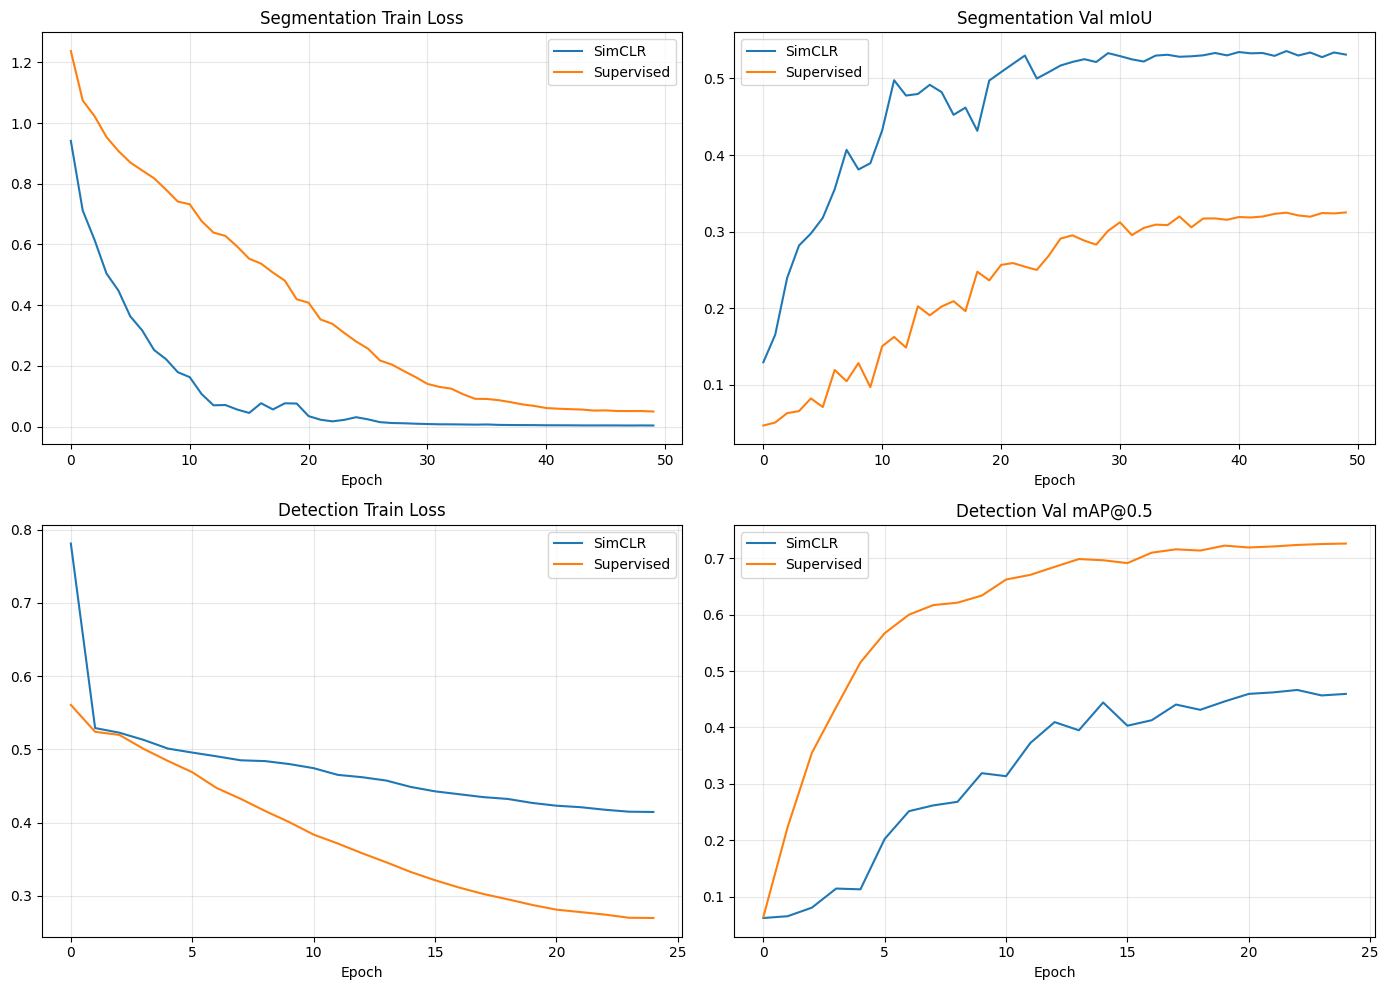

saved curves.png


In [23]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(seg_hist_simclr['train_loss'], label='SimCLR')
axes[0, 0].plot(seg_hist_sup['train_loss'], label='Supervised')
axes[0, 0].set_title('Segmentation Train Loss')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(seg_hist_simclr['val_miou'], label='SimCLR')
axes[0, 1].plot(seg_hist_sup['val_miou'], label='Supervised')
axes[0, 1].set_title('Segmentation Val mIoU')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(det_hist_simclr['train_loss'], label='SimCLR')
axes[1, 0].plot(det_hist_sup['train_loss'], label='Supervised')
axes[1, 0].set_title('Detection Train Loss')
axes[1, 0].legend()
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(det_hist_simclr['val_map'], label='SimCLR')
axes[1, 1].plot(det_hist_sup['val_map'], label='Supervised')
axes[1, 1].set_title('Detection Val mAP@0.5')
axes[1, 1].legend()
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('curves.png', dpi=150)
plt.show()
print('saved curves.png')